In [126]:
from qiskit import *
%matplotlib inline

In this brief tutorial, I aim to walk you through a classic error mitigation workflow using qiskit.ignis so that you understand the why behind everything we're doing. It's important to note, that these principles work just as well when scaling the number of qubits. We'll first start by creating a circuit to test on an actual quantum computer so that we can obtain the noise model. The actual circuit you use doesn't matter since all we care about are the deviations from an arbitrary ideal state. But let's go with a bell state, those are easy to visualize since there are only two ideal states.

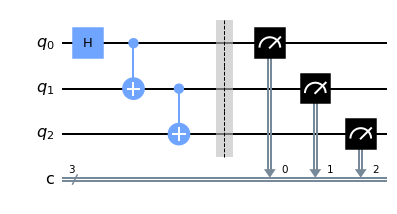

In [127]:
nqubits = 3
circuit = QuantumCircuit(nqubits,nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.barrier()
circuit.measure([0,1,2],[0,1,2])
circuit.draw(output='mpl')

Let's simulate the circuit on a quantum circuit simulator to get a feel for what the ideal measurements should look like.

In [113]:
simulator = Aer.get_backend('qasm_simulator')
results = execute(circuit, backend=simulator, shots=1024).result()

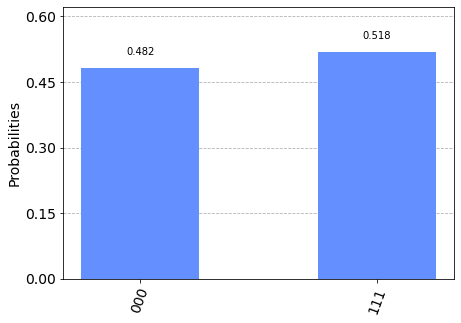

In [114]:
from qiskit.visualization import plot_histogram
plot_histogram(results.get_counts(circuit))

In [24]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')

ibmqfactory.load_account:WARNING:2020-11-10 07:37:08,620: Credentials are already in use. The existing account in the session will be replaced.


Let's try the same circuit on an actual quantum computer now!

In [115]:
job = execute(circuit, backend=device, shots=1024)
print(job.job_id)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x00000233F080EC40>>
Job Status: job has successfully run


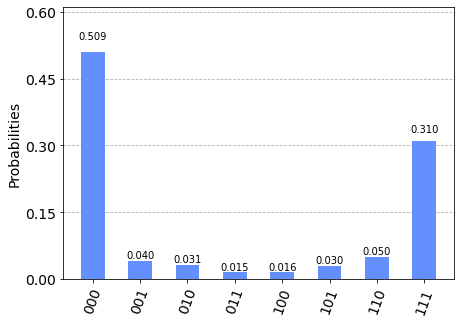

In [116]:
# execute
device_results = job.result()
plot_histogram(device_results.get_counts(circuit))

As observed above, quantum noise has given us measurements that are neither of the ideal states. In a purely theoretical sense, our circuit should output an even split of 111 and 000. To get a clearer picture of what the ideal measurements should actually look like, we can apply some post-processing to the results so that it filters out the 'invalid' states. This is what we call error mitigation.

We're going to split the quantum circuit into several quantum circuits so that each represent the computational basis state measurements of our overall circuit. These quantum circuits are what we call calibration circuits. So since we have a circuit with 4 qubits, we're going to break that into 16 computational basis states so that we can calibrate each one individually.

Note that the computational basis state of each circuit is the state label.

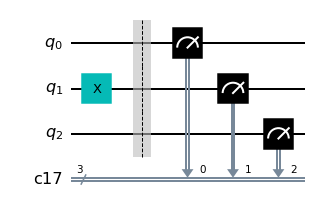

In [117]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr  = circuit.qregs[0], circlabel='measerrormitigationcal')
# Let's draw an arbitrary calibration circuit to look at an example
cal_circuits[2].draw(output= 'mpl')

In [128]:
# Note that we have 8 computational basis states, hence we have 8 calibration circuits
len(cal_circuits)

8

Let's run all of our calibration circuits on a real quantum computer to gauge how much we need to calibrate each computational basis state to so that we filter out the noise.

In [119]:
cal_job = execute(cal_circuits,
                  backend=device,
                  shots=1024,
                  optimization_level=0,
                  )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

5fab5ecd3b553100132dd647
Job Status: job has successfully run


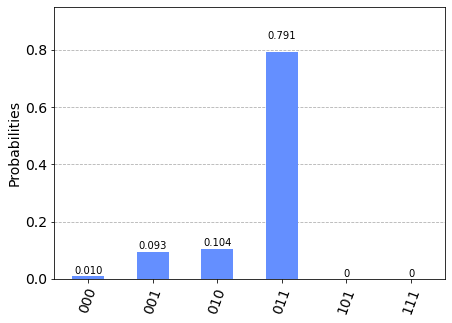

In [120]:
# Visualizing counts of an arbitrary calibration circuit
# Notice that we only measure the basis state 75-85% of the time, theoretically it should be 100%
plot_histogram(cal_results.get_counts(cal_circuits[3]))

A histogram is nice, but density matrices are better suited to visualize the measurements. Next, we're going to fit these results into a density matrix that shows the measured state for each prepared state. The prepared states is what the measurement of the calibration circuit should have been. In a zero-noise environment, we'd have an identity matrix (1s along the diagonal) since each prepared state would be equivalent to the measured state. But of course, since we're in the NISQ era for quantum computers, we'll have greyish clouds near each ideal state which represent the off-target measurements.

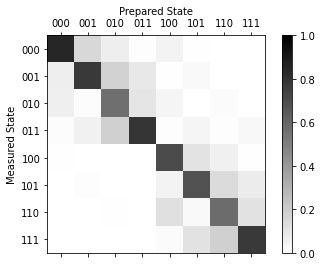

In [121]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_fitter.plot_calibration()

Given the density matrix, we now know the probabilities of each off-target measurement. Since this is a probability matrix, all of the values in each column squared are normalized. What we're going to do next is filter out all of the off-target measurements (not on the diagonal). 

If you're interested in the math behind this, I implore you to look into Chapter 5.2 in the Qiskit textbook. The short summary is that the density matrix above applied to the ideal state gives us the noisy results. So if we follow that logic, we can apply the inverse of that noisy matrix to the noisy results to obtain the ideal state.

In [122]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_results)

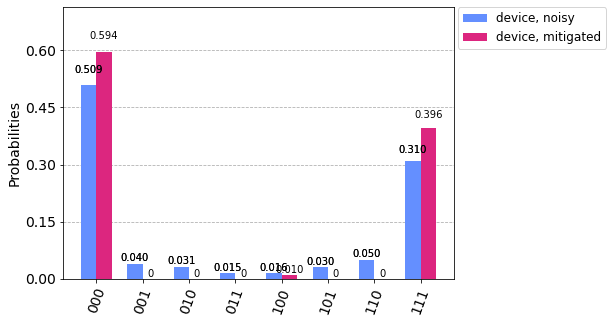

In [123]:
# Let's visualize the difference between the counts before and after our error mitigation
device_counts = device_results.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

Hurrah! Virtually all of the unintended measurement states have been filtered out.

So we have now made a filter (inverse matrix) that can be applied to any 3 qubit circuit to filter out any off-target measurements. Note that our filter will work best when applied to circuits that have been run on the same quantum computer given that it's the noise model that we calibrated our filter for. Let's try applying our filter to the generic circuit I first showed you!

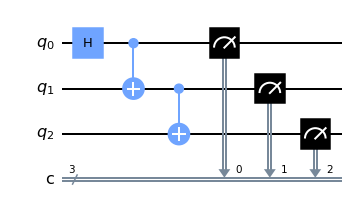

In [61]:
# Just recreating that same circuit
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2],[0,1,2])
circuit.draw(output='mpl')

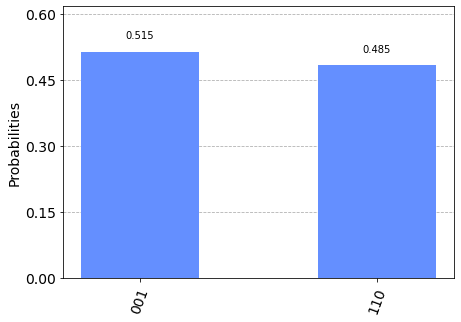

In [62]:
# Plotting ideal measurements using Aer simulator...
plot_histogram(execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2))

In [124]:
# Executing on an actual quantum computer to check out the raw measurements
device_counts_2 = execute(circuit2, backend=device, shots=1024).result().get_counts()

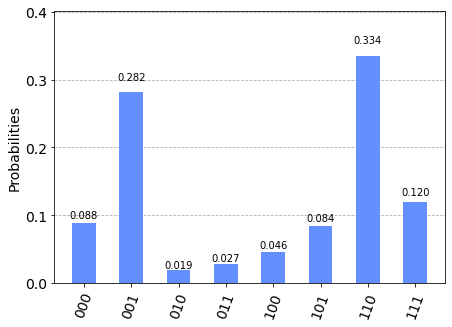

In [125]:
plot_histogram(device_counts_2)

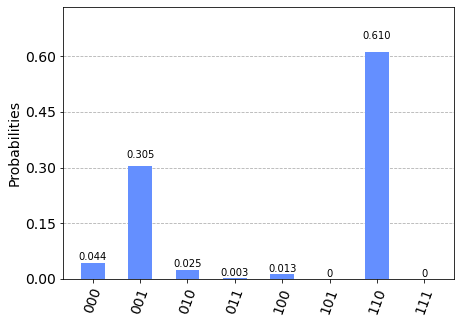

In [65]:
# Applying our filter on the results 
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)
plot_histogram(device_mitigated_counts_2)